#Flow passes an obstacle
In this notebook, we will use boundary element method to solve the problem of a potential flow passing an circle obstacle in the channel.

In [53]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
eps=1e-10

The problem involves a tube having length $L_x$ and width $L_y$ with a circle obstacle having radius $R$ lying in the middle of the channel (Fig. 1). The goal is to study the steady flow profile when an inlet velocity $u_0$ is provided. 
A standard procedure to solve a potential flow problem starts with the Laplace's equation for velocity potential:

$$
\begin{equation*}
\nabla ^2 \phi=0
\tag{1}\end{equation*}
$$

If the boundary values of $\phi$ are known, one can solve for $\phi$ in the whole domain using BEM and then compute the flow velocity using:

$$
\begin{equation*}
\mathbf{u}=\nabla \phi
\tag{2}\end{equation*}
$$

BEM, however, can only be used if $\phi$ on a closed boundary surface is known. In this situation, where there exist two closed surface: the outer rectangle and the inner circle, this method cannot be used. To resolve this, we make use of the axis symmetry of the geometry through the Ox line. With this symmetry, the velocity profile in the two halves of the channel, seperated by the line Ox, should be identical. Therefore, the problem can be modified as solving the flow in a channel as in Fig. 2. The boundary conditions for velocity potential are also given in the same figure.

<img src="Figure 2-1.jpg"/> 

<img src="Figure 2-2.jpg"/> 

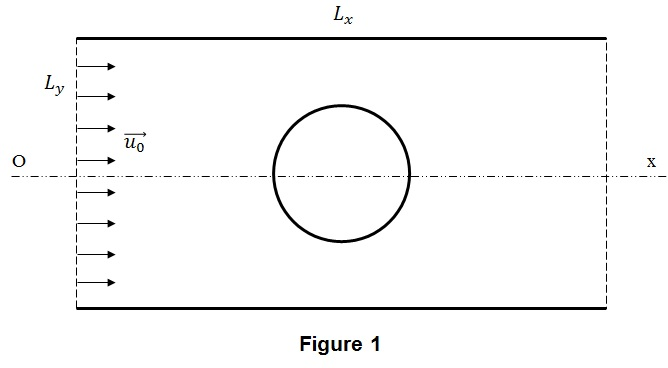

In [58]:
from IPython.display import Image
Image(filename=('D:\Dropbox\Study\Numerical methods for advanced fluids dynamics\Assignments\Assignment 3\Figure\Figure 2-1.JPG'))

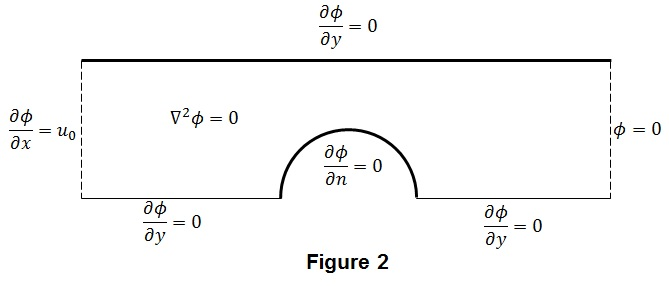

In [57]:
Image(filename=('D:\Dropbox\Study\Numerical methods for advanced fluids dynamics\Assignments\Assignment 3\Figure\Figure 2-2.JPG'))

In [2]:
def CalcF(xi,eta,xk,yk,nkx,nky,L):
    A=L**2.
    B=2.*L*(-nky*(xk-xi)+nkx*(yk-eta))
    E=(xk-xi)**2.+(yk-eta)**2.
    M=np.sqrt(np.fabs(4.*A*E-B**2.))
    BA=B/A
    EA=E/A
    if (M<eps):
        F1=0.5/np.pi*L*(np.log(L)+(1+0.5*BA)*np.log(np.fabs(1+0.5*BA))-\
                          1-0.5*BA*np.log(np.fabs(0.5*BA)))
        F2=0.
    else:
        F1=1./np.pi*0.25*L*(2.*(np.log(L)-1.)-0.5*BA*np.log(np.fabs(EA))+\
                   (1.+0.5*BA)*np.log(np.fabs(1.+BA+EA))+\
                   (M/A)*(np.arctan((2.*A+B)/M)-np.arctan(B/M)))
        F2=1./np.pi*L*(nkx*(xk-xi)+nky*(yk-eta))/M*(np.arctan((2.*A+B)/M)-np.arctan(B/M))
        
    return F1,F2

In [3]:
def CELAP1(N,xm,ym,xb,yb,nx,ny,lg,BCT,BCV):
    B=np.zeros(N)
    A=np.zeros((N,N))
    phi=np.zeros(N)
    dphi=np.zeros(N)
    for m in range(N):
        for k in range(N):
            F1,F2=CalcF(xm[m],ym[m],xb[k],yb[k],nx[k],ny[k],lg[k])
            if (k==m):
                delta=1.
            else:
                delta=0.
            if (BCT[k]==0):
                A[m,k]=-F1
                B[m]=B[m]+BCV[k]*(-F2+.5*delta)
            else:
                A[m,k]=F2-0.5*delta
                B[m]=B[m]+BCV[k]*F1
                
    Z=np.linalg.solve(A,B)
    
    for m in range(N):
        if (BCT[m]==0):
            phi[m]=BCV[m]
            dphi[m]=Z[m]
        else:
            phi[m]=Z[m]
            dphi[m]=BCV[m]
    
    return phi, dphi       

In [4]:
def CELAP2(N,xi,eta,xb,yb,nx,ny,lg,phi,dphi):
    mysum=0.
    for i in range(N):
        F1,F2=CalcF(xi,eta,xb[i],yb[i],nx[i],ny[i],lg[i])
        mysum=mysum+phi[i]*F2-dphi[i]*F1
    return mysum

In [22]:
#======THE MAIN PROGRAM======#

#------Input parameters------#

#Inlet velocity:
u0=2.0
#Wall length
Lx=2.0; Ly=1.0
lx=Lx; ly=Ly/2
#Radius of object
R=0.2
#Location of object
l_R=1.
#Number of elements per side:
N0=50
#Total number of elements
N=5*N0
#Gridlength
dlx=lx/N0; dly=ly/N0

#-------Calculate boundary values of phi-------#

#Position of the corners
xb=np.zeros(N+1)
yb=np.zeros(N+1)
#Position of the midpoint
xm=np.zeros(N)
ym=np.zeros(N)
#Element length
lg=np.zeros(N)
#Normal vector
nx=np.zeros(N)
ny=np.zeros(N)
#Type of boundary condition
BCT=np.zeros(N)
#Values of boundary condition
BCV=np.zeros(N)

#Position of the boundaries:

#The bottom boundary with the circular object should have finer mesh
N_R=2*N0-(lx-2*R)/dlx  #number of elements in the half circle
i_b=(l_R-R)/dlx  #beginning point of the circle
i_e=i_b+N_R  #end point of the circle

for i in range (2*N0):                         
    if (i<=i_b):
        xb[i]=i*dlx
        yb[i]=0
    elif ((i_b<i) and (i<i_e)):
        xb[i]=l_R+R*np.cos(np.pi*(1-(i-i_b)/N_R))
        yb[i]=np.sqrt(R**2-(xb[i]-l_R)**2)
    else:
        xb[i]=lx-(2*N0-i)*dlx
        yb[i]=0

for i in range (N0):
    xb[2*N0+i]=lx              #right
    yb[2*N0+i]=i*dly
    
    xb[3*N0+i]=N0*dlx-i*dlx       #top
    yb[3*N0+i]=ly
    
    xb[4*N0+i]=0.                #left
    yb[4*N0+i]=N0*dly-i*dly
    

xb[N]=xb[0]
yb[N]=yb[0]

#Position of midpoints + length of elements + normal vectors
for i in range (N):
    xm[i]=0.5*(xb[i]+xb[i+1])      # midpoints
    ym[i]=0.5*(yb[i]+yb[i+1])
    
    lg[i]=np.sqrt((xb[i+1]-xb[i])**2.+(yb[i+1]-yb[i])**2.)     #length
    
    nx[i]=(yb[i+1]-yb[i])/lg[i]      #normal vector
    ny[i]=(-xb[i+1]+xb[i])/lg[i]
    
#Setup boundary conditions
for i in range (N):
    if (i<2*N0):           #bottom
        BCT[i]=1
        BCV[i]=0.
        
    elif (i<3*N0):       #right
        BCT[i]=0
        BCV[i]=0
        
    elif (i<4*N0):       #top
        BCT[i]=1
        BCV[i]=0
        
    else:                #left
        BCT[i]=1
        BCV[i]=u0


#Calculate all boundary values
phi,dphi=CELAP1(N,xm,ym,xb,yb,nx,ny,lg,BCT,BCV)

#------Calculate velocity potential for the domain-------#

#Generate the grid:
Nx=4*N0; Ny=N0
dx=lx/(Nx); dy=ly/(Ny)
x=np.linspace(0.,lx,Nx+1); y=np.linspace(0.,ly,Ny+1)
X,Y=np.meshgrid(x,y)
phi_bem=np.zeros((Ny+1,Nx+1))

#Calculate potential for the whole domain:
for i in range (1,Ny):
    for j in range (1,Nx):
        if (((X[i,j]-l_R)**2+Y[i,j]**2)>R**2):
            phi_bem[i,j]=CELAP2(N,X[i,j],Y[i,j],xb,yb,nx,ny,lg,phi,dphi)
            
#Calculate the potential for the boundary:
for i in range (1,Nx):
    phi_bem[0,i]=phi_bem[1,i]     #top
    phi_bem[Ny,i]=phi_bem[Ny-1,i]     #bottom

for i in range (1,Ny):
    phi_bem[i,0]=phi_bem[i,1]-u0*dx    #left
    phi_bem[i,Nx]=0    #right
    
#-------Calculate the velocity--------#
#Initialize the grid:
u=np.zeros((Ny+1,Nx+1))
v=np.zeros((Ny+1,Nx+1))

#Calculate the velocity for the whole domain
u[1:-1,1:-1]=0.5/dx*(phi_bem[1:-1,0:-2]-phi_bem[1:-1,2:])
v[1:-1,1:-1]=0.5/dy*(phi_bem[0:-2,1:-1]-phi_bem[2:,1:-1])

#Force the fluid velocity in the region of the circular object to be 0:
for i in range (Ny):
    for j in range (Nx):
        if (((X[i,j]-l_R)**2+Y[i,j]**2-(R+dx)**2)<0):
            u[i,j]=0; v[i,j]=0

#Apply boundary condition for velocity
u[:,0]=u0; v[:,0]=0        #inlet
u[0,:]=0; v[0,:]=0          #top wall
v[Ny,:]=0         #bottom wall
u[:,Nx]=u[:,Nx-1]; v[:,Nx]=v[:,Nx-1]     #outlet

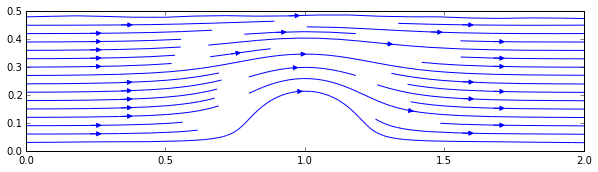

In [31]:
#plot the graph
fig=plt.figure(figsize=(10,2.5), dpi=300)
plt.streamplot(X,Y,u,v,density=0.6)

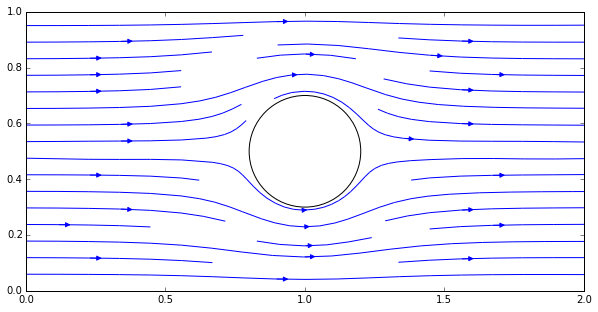

In [52]:
#------Plot the velocity of the whole domain------#

#Generate new grid:
Nx=4*N0; Ny=2*N0
xx=np.linspace(0.,Lx,Nx+1); yy=np.linspace(0.,Ly,Ny+1)
XX,YY=np.meshgrid(xx,yy)
uu=np.zeros((Ny+1,Nx+1))
vv=np.zeros((Ny+1,Nx+1))
            
for i in range (Ny):
    for j in range (Nx):
        if (i<=(Ny/2)):
            uu[i,j]=u[Ny/2-i,j]; vv[i,j]=-v[Ny/2-i,j]
        else:
            uu[i,j]=u[i-Ny/2,j]; vv[i,j]=v[i-Ny/2,j]

#Plot the graph:
fig=plt.figure(figsize=(10,5), dpi=300)
a=plt.gca()
plt.streamplot(XX,YY,uu,vv,density=0.6)
c1=a.add_patch(plt.Circle((Lx/2,Ly/2),R,facecolor="white"))